<a href="https://colab.research.google.com/github/chrisporras/graddiss/blob/main/GradientDissentersHackathon2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon 2023
ML for Biomedical Data Science
Team Gradient Dissenters

Members: Audrey Lee, Christian Porras, Joy Jiang

# **MODEL 1: PRETRAINED RESNET50**



## I. Install and load Kaggle mammography

In [ ]:
# Clone project git repo
!git clone https://github.com/chrisporras/graddiss.git

Cloning into 'graddiss'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), 92.29 KiB | 1.49 MiB/s, done.


In [ ]:
# install Kaggle public api
! pip install -q kaggle
# Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
! cp ./graddiss/kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json
#Change the permissions of the file.
! kaggle datasets list

ref                                                      title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide     Covid Cases and Deaths WorldWide           8KB  2023-02-01 12:22:51          11392        380  1.0              
naveenkumar20bps1137/walmart-sales-analysis              WALMART SALES ANALYSIS                   119KB  2023-03-03 18:02:11           1825         50  0.9411765        
datascientistanna/customers-dataset                      Shop Customer Data                        23KB  2023-02-07 18:42:21           9816        222  1.0              
ulrikthygepedersen/co2-emissions-by-country              CO2 Emissions                            114KB  2023-02-28 12:39:49            876         28

In [ ]:
!kaggle competitions download -c mammography-image-patch-classification-2023

 98% 450M/460M [00:05<00:00, 88.9MB/s]
100% 460M/460M [00:05<00:00, 89.1MB/s]


In [ ]:
# data directory
!mkdir data
# unzip data there,
!unzip mammography-image-patch-classification-2023.zip -d data

## II. Prepare data.
### A. Create datasets.

In [ ]:
# Configuration class
class Config:
    resize = False
    batch_size = 64
    numworkers = 2

In [ ]:
# CustomImageDataset class
import numpy as np
import os
import torch
from PIL import Image
import torchvision
from skimage import io, img_as_float32
import numpy as np
import torch

class ToTensor3D(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image):
        image = img_as_float32(image)
        # The following two lines are to duplicate the grayscale image onto
        # 3 channels. That's to make the input compatible with those models
        # trained on color images. If you don't use pretrained models, you can
        # delete these two lines.
        new_shape = (3,) + image.shape
        dup_img = np.broadcast_to(image, new_shape)

        # Normalize if needed.
        # normalize0, normalize1 = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
        # normalize = torchvision.transforms.Normalize(normalize0, normalize1)
        # image_tensor = normalize(dup_img)

        return torch.from_numpy(dup_img.copy())
        # torch.from_numpy

transform = ToTensor3D()

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df):
        # Create one iterable that get be __getitemed__
        self.image_dir = image_dir
        self.df = df

    def __len__(self): # Denotes the total number of samples
        return self.df.shape[0]

    def __getitem__(self, index): # Generates one sample of data
        label = torch.tensor(self.df.iloc[index]['label_num'],dtype=torch.long) 

        # Goes to image_tensor below
        image_path = os.path.join(self.image_dir, self.df.iloc[index]['img_name'])
        image_og = Image.open(image_path)
        image = transform(image_og)

        # Resize, depending on the network
        if Config.resize:
            resize = torchvision.transforms.Resize(384)
            image = resize(image)
        
        return image, label

In [ ]:
import pandas as pd

# New numeric labels.
labels_num = {'background': 0, 'calc_ben': 1, 'calc_mal': 2, 'mass_ben': 3, 'mass_mal': 4}

# Create datasets
traindf = pd.read_csv('data/train.csv') 
# traindf['label'] = traindf['label'].astype(int) # Can't convert string to int :) 
traindf['label_num'] = traindf['label'].map(labels_num)
train_dataset = CustomImageDataset('data/train_imgs', traindf)

testdf = pd.read_csv('data/test.csv') 
# testdf['label'] = testdf['label'].astype(int) # Can't convert string to int :) 
test_dataset = CustomImageDataset('data/test_imgs', testdf)

print(traindf.head())

        id     label     img_name  label_num
0  P000001  calc_ben  P000001.png          1
1  P000002  calc_ben  P000002.png          1
2  P000003  mass_ben  P000003.png          3
3  P000004  mass_mal  P000004.png          4
4  P000005  calc_mal  P000005.png          2


In [ ]:
# Examine paths.
label = traindf.iloc[1]['label']

image_path = os.path.join('data/train_imgs', traindf.iloc[1]['img_name'])
print(label)
print(image_path)

calc_ben
data/train_imgs/P000002.png


### B. Create dataloaders.

In [ ]:
train_size = int(0.5 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_data, test_data = torch.utils.data.random_split(
    train_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train_data, Config.batch_size, shuffle=True, num_workers=Config.numworkers)
test_loader = torch.utils.data.DataLoader(
    test_data, Config.batch_size, shuffle=False, num_workers=Config.numworkers) 


## III. Try ResNet50

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Evaluate function
def model_eval(model, loader_, criterion):
    # Test the model
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader_:
            data = data.to(device) # Calculate on GPU
            target = target.to(device)
            output = model(data)
            eval_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item() # Compare to target and calculate accuracy

    eval_loss /= len(loader_)
    eval_acc = correct/len(loader_.dataset)
    return eval_loss, eval_acc

In [ ]:
import time

# Initialize the model, loss function, and optimizer
model = models.resnet50(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Change the output to 5 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Get start time
start_time = time.time()

# Train the model
model = model.to(device)
best_acc = 0
epoch_ls = []
train_loss_ls = []
val_loss_ls = []
train_acc_ls = []
val_acc_ls = []

for epoch in range(10):
    model.train()
    train_loss = 0
    correct = 0

    # Gradient descent
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward() # Call backward propagation.
        optimizer.step() # Step in optimizer. 
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate metrics
    train_loss /= len(train_loader)
    train_acc = correct/len(train_loader.dataset)
    test_loss, test_acc = model_eval(model, test_loader, criterion)
    print('Train Epoch: {}\tLoss: {:.6f}\tAcc: {:.3f}'
          '\tVal - Loss:{:.6f}\tAcc:{:.3f}'.format(
              epoch, train_loss, train_acc, test_loss, test_acc))
    if test_acc > best_acc:
        torch.save(model.state_dict(), 'best_model1.pt') # Save the best model. 
    
    # Book-keep metrics
    epoch_ls.append(epoch)
    train_loss_ls.append(train_loss)
    val_loss_ls.append(test_loss)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(test_acc)
    
# Get end time
print("Total run time: %s seconds" % (time.time() - start_time))

# Test the model
# model.load_state_dict(torch.load('cifar_best_model.pt'))
# test_loss, test_acc = model_eval(model, test_loader, criterion)
# print('Test - Loss:{:.6f}\tAcc:{:.3f}'.format(test_loss, test_acc))

Train Epoch: 0	Loss: 1.202477	Acc: 0.521	Val - Loss:7.377901	Acc:0.452
Train Epoch: 1	Loss: 0.945556	Acc: 0.609	Val - Loss:61.424481	Acc:0.452
Train Epoch: 2	Loss: 0.868295	Acc: 0.648	Val - Loss:3.131942	Acc:0.385
Train Epoch: 3	Loss: 0.821258	Acc: 0.667	Val - Loss:12.976590	Acc:0.452
Train Epoch: 4	Loss: 0.778340	Acc: 0.678	Val - Loss:18.503911	Acc:0.452
Train Epoch: 5	Loss: 0.739732	Acc: 0.688	Val - Loss:87.110307	Acc:0.452
Train Epoch: 6	Loss: 0.721542	Acc: 0.709	Val - Loss:7.595497	Acc:0.452
Train Epoch: 7	Loss: 0.674895	Acc: 0.721	Val - Loss:3.158105	Acc:0.452
Train Epoch: 8	Loss: 0.641818	Acc: 0.741	Val - Loss:10.883988	Acc:0.452
Train Epoch: 9	Loss: 0.616113	Acc: 0.741	Val - Loss:4.183007	Acc:0.113
Total run time: 382.06275153160095 seconds


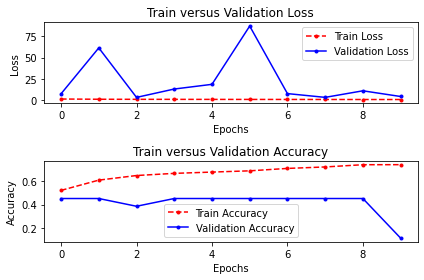

In [ ]:
# Initialize subplots
import matplotlib.pyplot as plt
figure, axis = plt.subplots(2, 1)

# Plot
import matplotlib.pyplot as plt
axis[0].plot(epoch_ls, train_loss_ls, '.r--', label='Train Loss')
axis[0].plot(epoch_ls, val_loss_ls, '.b-', label='Validation Loss')
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_title("Train versus Validation Loss")
axis[0].legend()

axis[1].plot(epoch_ls, train_acc_ls, '.r--', label='Train Accuracy')
axis[1].plot(epoch_ls, val_acc_ls, '.b-', label='Validation Accuracy')
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].set_title("Train versus Validation Accuracy")
axis[1].legend()

# Apply labels 
plt.tight_layout()
plt.show()